# Compile faster Lime and consistency of contributions 

You can compute your local contributions with the [Lime](https://github.com/marcotcr/lime) library and summarize them with Shapash.
One of the limitations of using Lime is the speed of calculation.
In this tutorial, we propose 2 ways to speed up the calculations.
Then, we look impacts on the contributions of these accelerated calculations.

Contents:
- Build a Binary Classifier (Random Forest)
- Create Explainer using Lime
- Compile Shapash SmartExplainer
- Use of multiprocessing
- Changing setting of the num_samples option
- Comparison of computing times
- Consistency of contributions

Data from Kaggle [Telco customer churn](https://www.kaggle.com/blastchar/telco-customer-churn)

In [1]:
from maif_datalab import utils
utils.set_proxy()

import warnings
warnings.filterwarnings("ignore")

import plotly
plotly.io.renderers.default = 'png'

In [2]:
import numpy as np
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lime.lime_tabular

from shapash import SmartExplainer
from category_encoders import OrdinalEncoder
import multiprocessing
from collections import namedtuple
from shapash.explainer.consistency import Consistency

## Building Supervized Model

Let's start by loading a dataset and building a model that we will try to explain right after.


In [3]:
from shapash.data.data_loader import data_loading

In [4]:
%%time
df = data_loading('telco_customer_churn')

CPU times: user 92.9 ms, sys: 13.9 ms, total: 107 ms
Wall time: 3.86 s


In [5]:
df = df.reset_index().drop('customerID', axis=1)

In [6]:
df['Churn'].replace('No', 0,inplace=True)
df['Churn'].replace('Yes', 1,inplace=True)

In [7]:
y_df = df['Churn']
X_df = df.drop('Churn', axis=1)

#### Encoding Categorical Features 

In [8]:
categorical_features = [col for col in X_df.columns if X_df[col].dtype == 'object']

encoder = OrdinalEncoder(
    cols=categorical_features,
    handle_unknown='ignore',
    return_df=True).fit(X_df)

X_df=encoder.transform(X_df)

#### Train / Test Split

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, train_size=0.75, random_state=1)

#### Model Fitting

In [10]:
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=3)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(min_samples_leaf=3)

## Compute Lime with Shapash

In [11]:
xpl_lime = SmartExplainer(
    model=rf,
    backend='lime',
    data=Xtest[0:100], 
    preprocessing=encoder,
)

In [12]:
%%time
xpl_lime.compile(x=Xtest[0:100])

CPU times: user 1min 30s, sys: 9min 1s, total: 10min 31s
Wall time: 14 s


The calculation times for 100 individuals are long, which is why we propose 2 ways to speed up these computation times.

These 2 ways are not yet integrated in Shapash.
Fortunately, Shapash allows user to calculate his own contributions and give them as input to Shapash objects to get plots, web app, report.


## Compute Lime with use of multiprocessing

Multiprocessing allows users to fully leverage multiple processors on a given machine.
Read this documentation if you want to know more [Multiprocessing](https://docs.python.org/3/library/multiprocessing.html)

In [14]:
# Function features_check Extract feature names from Lime Output to be used by shapash
def features_check(s):
    for w in list(Xtest.columns):
        if f' {w} ' in f' {s} ' :
            feat = w
    return feat

In [15]:
#Training Tabular Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(Xtest[0:100].values, 
                                                   mode='classification',
                                                   feature_names=Xtest[0:100].columns
                                                   )

In [16]:
#Definition of functions for multiproccessing
#For this example 4 cores are use
LogEntry = namedtuple("LogEntry", ['exp', 'index_row'])

contribution_list = []

def foo_pool(x):
    exp = explainer.explain_instance(Xtest[0:100].loc[x].values, rf.predict_proba, num_features=Xtest.shape[1])
    index_row = x
    return LogEntry(exp=exp, index_row=index_row)   

def log_result(result):    
    contribution_list.append((result.index_row,dict([[features_check(elem[0]),elem[1]] for elem in result.exp.as_list()])))

def apply_async_with_callback():
    pool = multiprocessing.Pool(4)
    for row in Xtest[0:100].index:
        pool.apply_async(foo_pool, args=(row,), callback = log_result)  
    pool.close()
    pool.join()    


Compute Lime contributions with multiprocessing

In [17]:
%%time
contribution_list = []
apply_async_with_callback()

CPU times: user 268 ms, sys: 198 ms, total: 466 ms
Wall time: 8.59 s


By applying multiprocessing on 4 cores, the calculation time is almost divided by 4

In [18]:
#transformation into a dataframe with the same column and row sorting as lime contribution dataset
contribution_multiprocessing = pd.DataFrame(pd.concat([pd.DataFrame(list(pd.DataFrame(contribution_list).iloc[:,0]),columns=['index']),
           pd.DataFrame(list(pd.DataFrame(contribution_list).iloc[:,1]))], axis=1).set_index('index'))
contribution_multiprocessing = contribution_multiprocessing[pd.DataFrame(xpl_lime.contributions[1]).columns]
contribution_multiprocessing = contribution_multiprocessing.reindex(xpl_lime.contributions[1].index)

### validation multiprocessing compute

To validate that the results of the contribution calculation with multiprocessing are equivalent to the Lime calculation, we can use the object Consistency.

The Consistency metric compares methods between them and evaluates how close the explanations are from each other.

To see more details : https://github.com/MAIF/shapash/blob/master/tutorial/explainability_quality/tuto-quality01-Builing-confidence-explainability.ipynb

In [19]:
#creation of the contribution dict for Consistency object
contributions = { "lime":pd.DataFrame(xpl_lime.contributions[1]).reset_index(drop=True),
                  "Lime_multiprocessing":contribution_multiprocessing.reset_index(drop=True)}


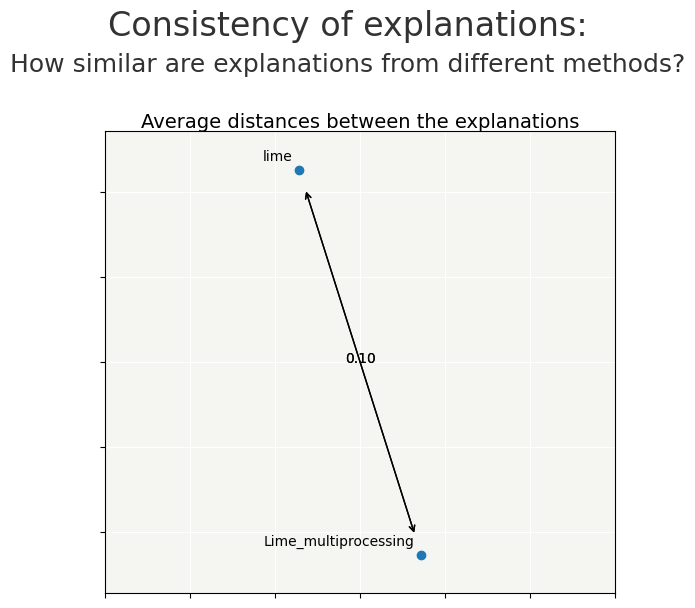

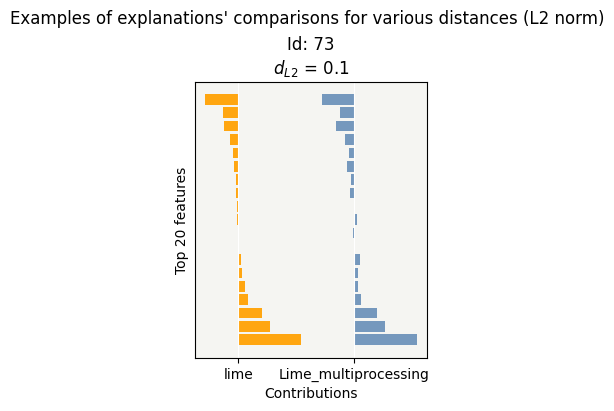

In [20]:
cns = Consistency()
cns.compile(contributions=contributions)
cns.consistency_plot()

Lime works with a substitution model, which generates randomness.

The distance between the contributions by the 2 calculations is small. 

### Verification that the distance difference is due to the Lime

we recompile Lime to compare the differences

In [21]:
xpl_lime2 = SmartExplainer(
    model=rf,
    backend='lime',
    data=Xtest[0:100],
    preprocessing=encoder,
)

In [22]:
%%time
xpl_lime2.compile(x=Xtest[0:100])

CPU times: user 1min 33s, sys: 9min 21s, total: 10min 54s
Wall time: 14.4 s


In [23]:
contributions = { "lime":pd.DataFrame(xpl_lime.contributions[1]).reset_index(drop=True),
                  "Lime_multiprocessing":contribution_multiprocessing.reset_index(drop=True),
                  "lime2":pd.DataFrame(xpl_lime2.contributions[1]).reset_index(drop=True)}

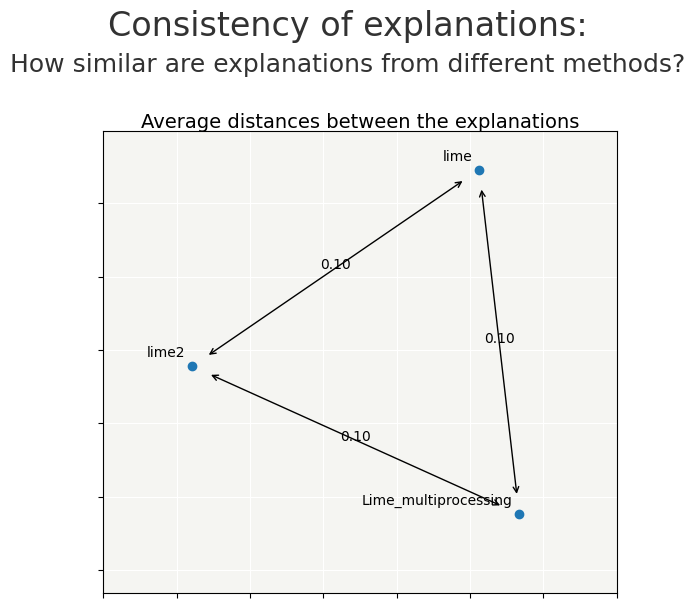

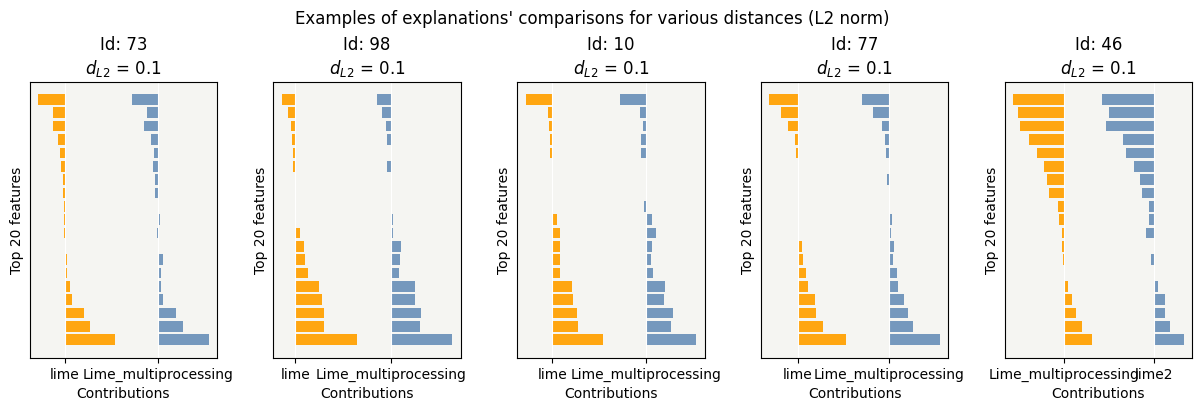

In [24]:
cns = Consistency()
cns.compile(contributions=contributions)
cns.consistency_plot()

## Compute Lime by changing parameter num_samples

num_samples is the size of the neighborhood to learn the linear model. By default num_samples is 5000

if num_samples is smaller, substitution model will be less accurate, and compute will be faster

let's test reducing num_samples to 2000 to see the time saving and the impact on the contributions

In [25]:
%%time
# Compute local Lime Explanation for each row in Test Sample
contrib_2000=[]
for ind in Xtest[0:100].index:
    exp = explainer.explain_instance(Xtest[0:100].loc[ind].values, rf.predict_proba, num_features=Xtest[0:100].shape[1],num_samples=2000)
    contrib_2000.append(dict([[features_check(elem[0]),elem[1]] for elem in exp.as_list()]))

CPU times: user 50.6 s, sys: 5min 3s, total: 5min 53s
Wall time: 7.57 s


In [26]:
contribution_df =pd.DataFrame(contrib_2000,index=Xtest[0:100].index)
Lime2000 = contribution_df[list(Xtest[0:100].columns)]

In [27]:
contributions = { "Lime5000":pd.DataFrame(xpl_lime.contributions[1]).reset_index(drop=True),
                  "Lime2000":Lime2000.reset_index(drop=True)}

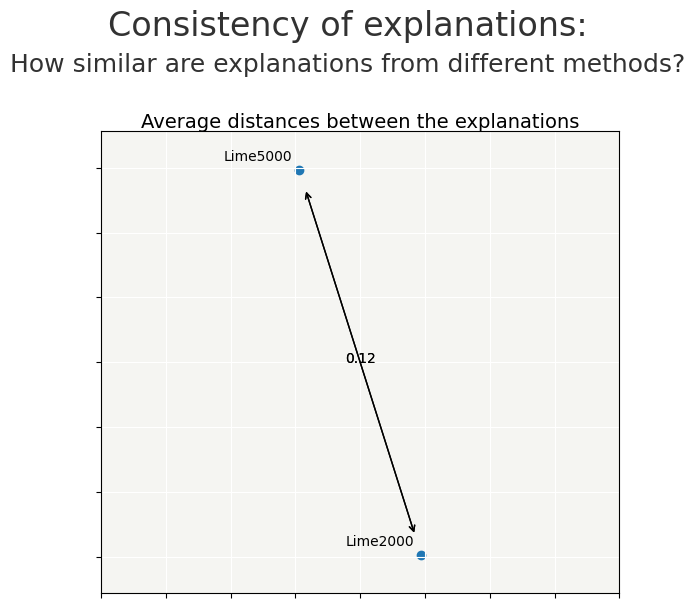

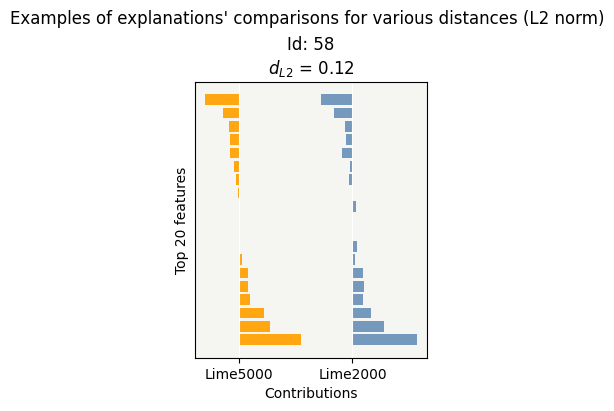

In [28]:
cns = Consistency()
cns.compile(contributions=contributions)
cns.consistency_plot()

By changing the num_samples parameter from 5000 to 2000, the impact is quite small on the contributions and the time saving is close to 2.5

let's test reducing num_samples to 1000

In [29]:
%%time
# Compute local Lime Explanation for each row in Test Sample
contrib_1000=[]
for ind in Xtest[0:100].index:
    exp = explainer.explain_instance(Xtest[0:100].loc[ind].values, rf.predict_proba, num_features=Xtest[0:100].shape[1],num_samples=1000)
    contrib_1000.append(dict([[features_check(elem[0]),elem[1]] for elem in exp.as_list()]))

CPU times: user 34.8 s, sys: 3min 30s, total: 4min 4s
Wall time: 5.24 s


In [30]:
contribution_df =pd.DataFrame(contrib_1000,index=Xtest[0:100].index)
Lime1000 = contribution_df[list(Xtest[0:100].columns)]

In [31]:
contributions = { "Lime5000":pd.DataFrame(xpl_lime.contributions[1]).reset_index(drop=True),
                  "Lime2000":Lime2000.reset_index(drop=True),
                  "Lime1000":Lime1000.reset_index(drop=True)}

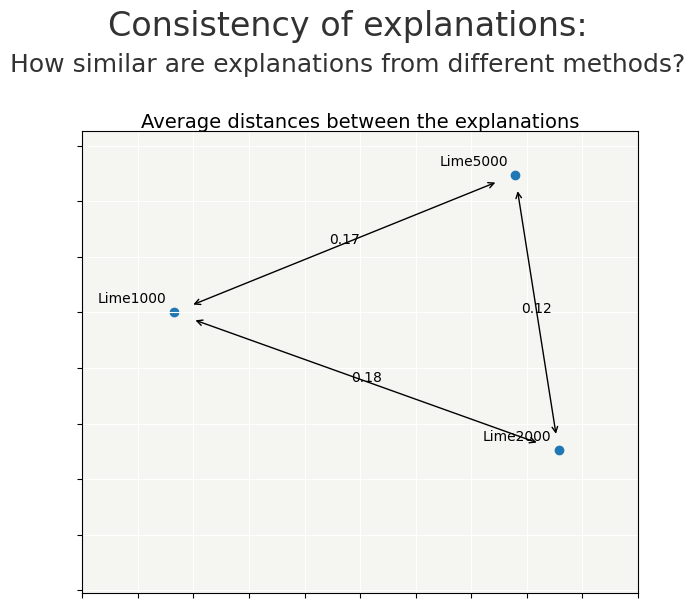

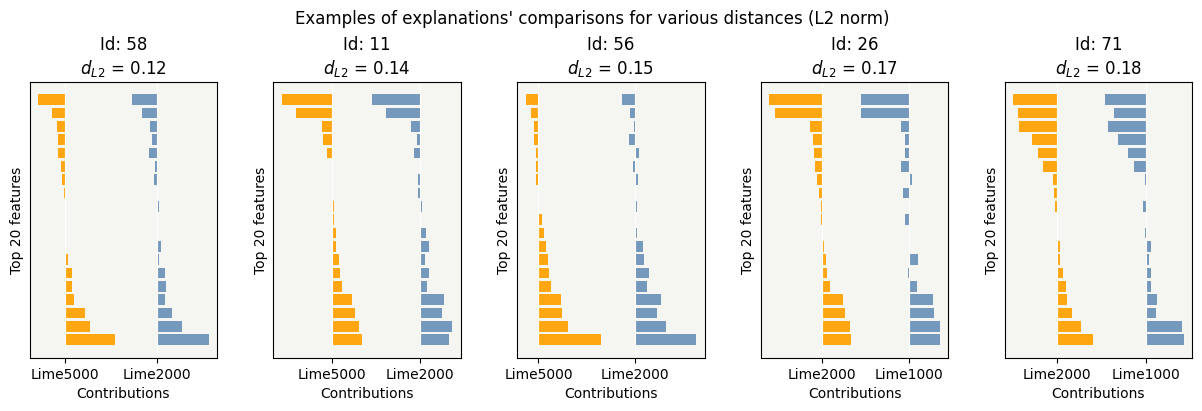

In [32]:
cns = Consistency()
cns.compile(contributions=contributions)
cns.consistency_plot()

Choice of the num_samples parameter may be a compromise between quality of explicability and computation time

### Comparison of the stability of explicabilities

To increase confidence in the explanation, measuring their stability is important.

We define stability as follows: if instances are very similar, then one would expect the explanations to be similar as well. Therefore, locally stable explanations are an important factor that help build trust around a particular explanation.

The similarity between instances is evaluated under two criteria: (1) the instances must be close in the feature space and (2) have similar model outputs.

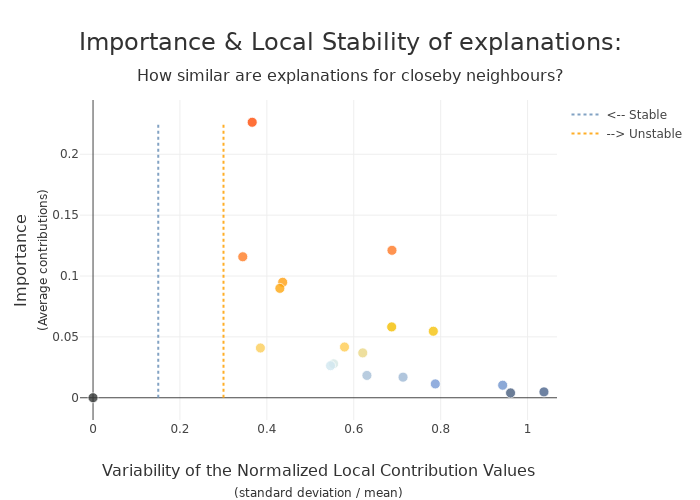

In [33]:
xpl_lime.plot.stability_plot()

In [34]:
xpl_lime2000 = SmartExplainer(
    model=rf,
    preprocessing=encoder
)

In [35]:
%%time
xpl_lime2000.compile(
    contributions=Lime2000,
    x=Xtest[0:100] 
)

CPU times: user 12 ms, sys: 2.36 ms, total: 14.4 ms
Wall time: 14.4 ms


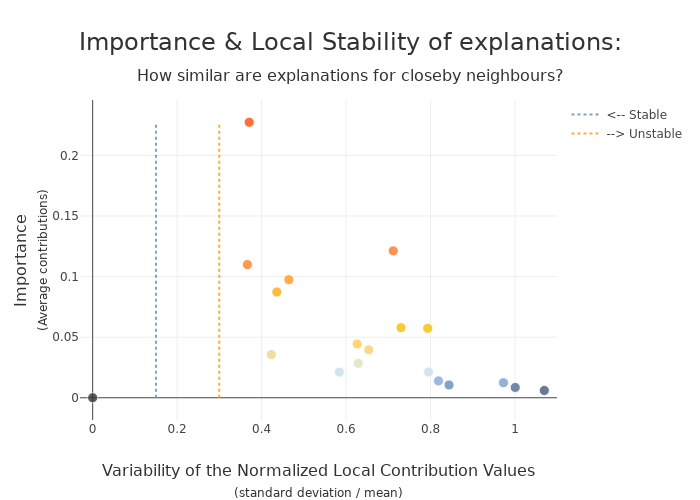

In [36]:
xpl_lime2000.plot.stability_plot()

In [37]:
xpl_lime1000 = SmartExplainer(
    model=rf,
    preprocessing=encoder  
)

In [38]:
%%time
xpl_lime1000.compile(
    contributions=Lime1000,
    x=Xtest[0:100],
)

CPU times: user 10.9 ms, sys: 760 µs, total: 11.7 ms
Wall time: 11.6 ms


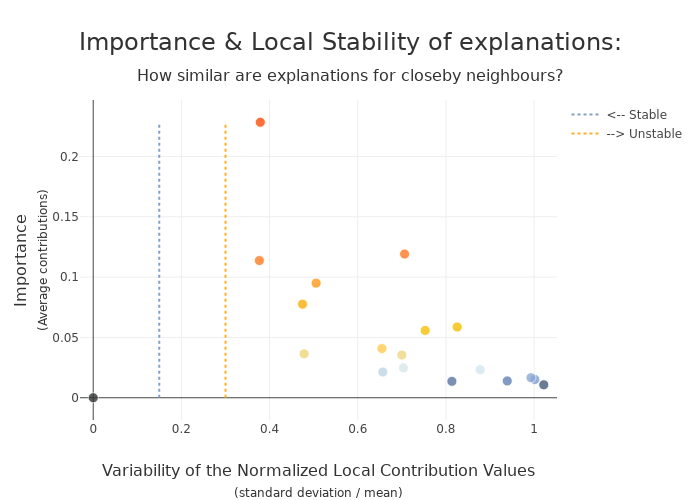

In [39]:
xpl_lime1000.plot.stability_plot()

The difference in stability is small

With this use case, changing num_samples saves computation time and has little impact on explainability.

We can look impacts using distance and object Consistency(), as well as comparing stability